## Problem Statement:- 

    - Modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques. 

### POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
nltk.download('universal_tagset')
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/thanush/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [3]:
# first few tagged sentences
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
# Split data into training and validation set in the ratio 95:5
random.seed(1234)
train_set, test_set = train_test_split(nltk_data, train_size=0.95, test_size=0.05)

print("Training Set Length -", len(train_set))
print("Testing Set Length -", len(test_set))
print("-" * 100)
print("Training Data -\n")
print(train_set[:10])

Training Set Length - 3718
Testing Set Length - 196
----------------------------------------------------------------------------------------------------
Training Data -

[[('Temple', 'NOUN'), ('also', 'ADV'), ('said', 'VERB'), ('0', 'X'), ('Sea', 'NOUN'), ('Containers', 'NOUN'), ("'", 'PRT'), ('plan', 'NOUN'), ('raises', 'VERB'), ('``', '.'), ('numerous', 'ADJ'), ('legal', 'ADJ'), (',', '.'), ('regulatory', 'ADJ'), (',', '.'), ('financial', 'ADJ'), ('and', 'CONJ'), ('fairness', 'NOUN'), ('issues', 'NOUN'), (',', '.'), ("''", '.'), ('but', 'CONJ'), ('did', 'VERB'), ("n't", 'ADV'), ('elaborate', 'VERB'), ('.', '.')], [('The', 'DET'), ('issue', 'NOUN'), ('is', 'VERB'), ('further', 'ADV'), ('complicated', 'ADJ'), ('*-1', 'X'), ('by', 'ADP'), ('uncertainty', 'NOUN'), ('over', 'ADP'), ('the', 'DET'), ('future', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('U.S.', 'NOUN'), ("'s", 'PRT'), ('leases', 'NOUN'), ('on', 'ADP'), ('military', 'ADJ'), ('bases', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('Ph

In [5]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
print(len(train_tagged_words))

test_tagged_words = [tup for sent in test_set for tup in sent]
print(len(test_tagged_words))

95851
4825


In [6]:
# Let's have a look at the tagged words in the training set
train_tagged_words[:10]

[('Temple', 'NOUN'),
 ('also', 'ADV'),
 ('said', 'VERB'),
 ('0', 'X'),
 ('Sea', 'NOUN'),
 ('Containers', 'NOUN'),
 ("'", 'PRT'),
 ('plan', 'NOUN'),
 ('raises', 'VERB'),
 ('``', '.')]

In [7]:
# Tokens in the train set - train_tagged_words
train_tagged_tokens = [tag[0] for tag in train_tagged_words]
train_tagged_tokens[:10]

['Temple',
 'also',
 'said',
 '0',
 'Sea',
 'Containers',
 "'",
 'plan',
 'raises',
 '``']

In [8]:
# POS tags for the tokens in the train set - train_tagged_words
train_tagged_pos_tokens = [tag[1] for tag in train_tagged_words]
train_tagged_pos_tokens[:10]

['NOUN', 'ADV', 'VERB', 'X', 'NOUN', 'NOUN', 'PRT', 'NOUN', 'VERB', '.']

In [9]:
# Building the train vocabulary to a set
training_vocabulary_set = set(train_tagged_tokens)
print(len(training_vocabulary_set))

12104


In [10]:
# Building the POS tags to a set
training_pos_tag_set = set(train_tagged_pos_tokens)
print(len(training_pos_tag_set))

12


### Build the vanilla Viterbi based POS tagger

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).

The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). 

Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 

####  Let's compute emission probabilties for a given word

In [11]:
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

#### Let's compute transition probabilties for a given word

In [12]:
# Compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [13]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(training_pos_tag_set), len(training_pos_tag_set)), dtype='float32')
for i, t1 in enumerate(list(training_pos_tag_set)):
    for j, t2 in enumerate(list(training_pos_tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [14]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(training_pos_tag_set), index=list(training_pos_tag_set))
tags_df

,X,PRON,.,ADV,NOUN,CONJ,ADP,PRT,NUM,ADJ,VERB,DET
X,0.074286,0.055238,0.163651,0.025873,0.062222,0.010476,0.143968,0.184762,0.002857,0.017460,0.204921,0.054286
PRON,0.093282,0.006526,0.039155,0.035317,0.209597,0.005374,0.023033,0.012668,0.007294,0.072169,0.485988,0.009597
.,0.027070,0.066470,0.093809,0.052890,0.221031,0.058072,0.090235,0.002502,0.081658,0.044045,0.088716,0.173412
ADV,0.023619,0.014637,0.136061,0.079508,0.031603,0.007319,0.119095,0.014305,0.032269,0.129408,0.342648,0.069528
NOUN,0.028767,0.004697,0.241060,0.016750,0.264438,0.042386,0.177117,0.043624,0.009577,0.012017,0.146275,0.013291
CONJ,0.008804,0.059778,0.035218,0.054680,0.347544,0.000463,0.052827,0.005097,0.042169,0.119092,0.159407,0.114921
ADP,0.034295,0.068697,0.040047,0.012781,0.322505,0.000746,0.017148,0.001491,0.063266,0.108318,0.008414,0.322292
PRT,0.013063,0.017309,0.043109,0.010124,0.245918,0.001960,0.020248,0.001960,0.057805,0.084259,0.401698,0.102547
NUM,0.211251,0.001465,0.117492,0.002637,0.351890,0.013771,0.034574,0.027249,0.185174,0.033109,0.017873,0.003516
ADJ,0.021196,0.000657,0.065067,0.004765,0.698160,0.017417,0.077719,0.011173,0.020703,0.066875,0.011830,0.004436


### EDA

In [15]:
# Importing libraries for heatmap
import matplotlib.pyplot as plt
import seaborn as sns

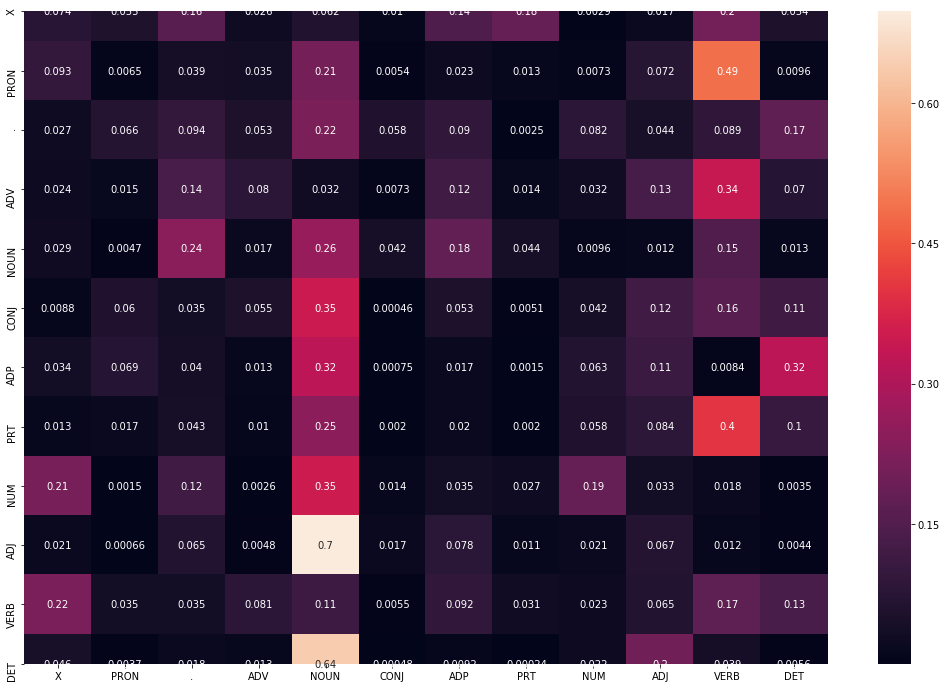

In [16]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df, annot = True)
plt.show()

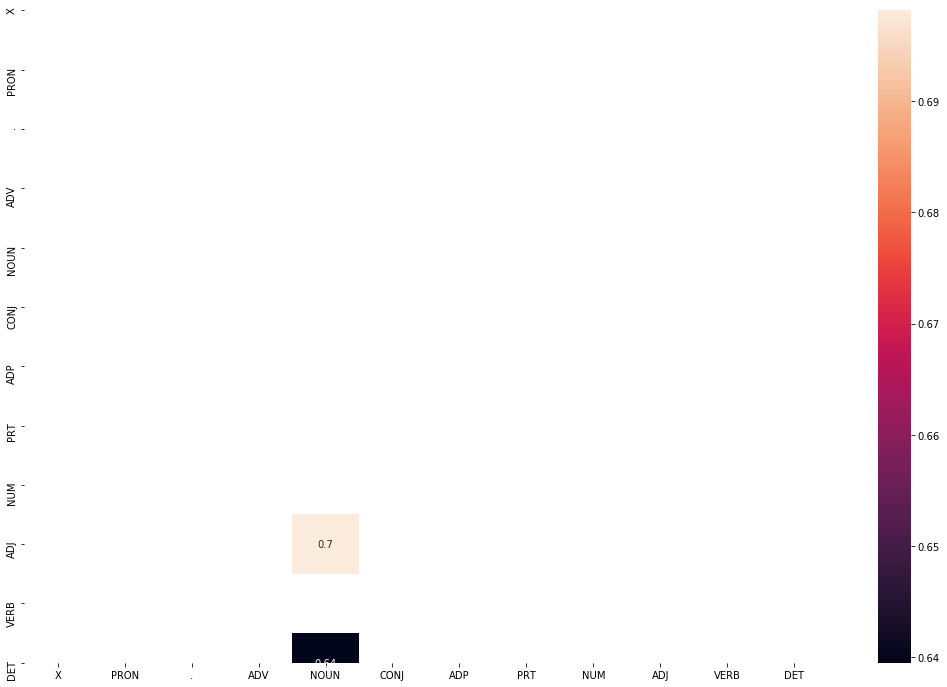

In [17]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent, annot = True)
plt.show()

### Viterbi Algorithm

The steps are as follows:

- Given a sequence of words.
- Iterate through the sequence
- For each word (starting from first word in sequence) calculate the product of emission probabilties and  transition probabilties for all possible tags.
- Assign the tag which has maximum probability obtained in step 3 above.
- Move to the next word in sequence to repeat steps 3 and 4 above.

In [18]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Evaluating Vanilla Viterbi Algorithm on Test Data

In [19]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('However', 'ADV'),
  (',', '.'),
  ('five', 'NUM'),
  ('other', 'ADJ'),
  ('countries', 'NOUN'),
  ('--', '.'),
  ('China', 'NOUN'),
  (',', '.'),
  ('Thailand', 'NOUN'),
  (',', '.'),
  ('India', 'NOUN'),
  (',', '.'),
  ('Brazil', 'NOUN'),
  ('and', 'CONJ'),
  ('Mexico', 'NOUN'),
  ('--', '.'),
  ('will', 'VERB'),
  ('remain', 'VERB'),
  ('on', 'ADP'),
  ('that', 'DET'),
  ('so-called', 'ADJ'),
  ('priority', 'NOUN'),
  ('watch', 'NOUN'),
  ('list', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('result', 'NOUN'),
  ('of', 'ADP'),
  ('an', 'DET'),
  ('interim', 'ADJ'),
  ('review', 'NOUN'),
  (',', '.'),
  ('U.S.', 'NOUN'),
  ('Trade', 'NOUN'),
  ('Representative', 'NOUN'),
  ('Carla', 'NOUN'),
  ('Hills', 'NOUN'),
  ('announced', 'VERB'),
  ('0', 'X'),
  ('*T*-1', 'X'),
  ('.', '.')],
 [('Dr.', 'NOUN'),
  ('Talcott', 'NOUN'),
  ('led', 'VERB'),
  ('a', 'DET'),
  ('team', 'NOUN'),
  ('of', 'ADP'),
  ('researchers', 'NOUN'),
  ('from', 'ADP'),
  ('the', 'DET'),
  ('National', 'NOUN')

In [20]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy_vanilla = len(check)/len(tagged_seq)
accuracy_vanilla

Time taken in seconds:  32.77009916305542


0.9426751592356688

In [21]:
# let's check the incorrectly tagged words
incorrect_tagged_words = [j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

print("Total Incorrect Tagged Words :", len(incorrect_tagged_words))
print("\n")
print("Incorrect Tagged Words :", incorrect_tagged_words)

Total Incorrect Tagged Words : 9


Incorrect Tagged Words : [(('India', 'X'), ('India', 'NOUN')), (('watch', 'VERB'), ('watch', 'NOUN')), (('apprehensive', 'X'), ('apprehensive', 'ADJ')), (('step', 'NOUN'), ('step', 'VERB')), (('that', 'ADP'), ('that', 'DET')), (('ago', 'ADP'), ('ago', 'ADV')), (('exchange', 'NOUN'), ('exchange', 'VERB')), (('preferred', 'ADJ'), ('preferred', 'VERB')), (('own', 'ADJ'), ('own', 'VERB'))]


Before proceeding for dealing with unknown words, lets first see how many unknown words we have. Unknows words would be those words that are present in the test set but not in the train set. That is the words the algorithm has not seen before.

In [22]:
# Unknown words 

test_vocabulary_set = set([t for t in test_tagged_words])

unknown_words = list(test_vocabulary_set - training_vocabulary_set)
print("Total Unknown words :", len(unknown_words))
print("\n")
print("Unknown Words :", unknown_words)

Total Unknown words : 3


Unknown Words : ['*T*-149', 'India', 'apprehensive']


### Solve the problem of unknown words

### Lexicon (Unigram) Tagger

In [23]:
# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(train_set)
accuracy_unigram_tagger = unigram_tagger.evaluate(test_set)
print("The accuracy of the Unigram Tagger is -", accuracy_unigram_tagger)

The accuracy of the Unigram Tagger is - 0.9110880829015544


In [24]:
# patterns for tagging using a rule based regex tagger -

patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense verbs
    (r'.*es$', 'VERB'),               # singular present verbs
    (r'.*ould$', 'VERB'),              # modal verbs
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'DET'),   # articles or determinants
    (r'.*able$', 'ADJ'),                # adjectives
    (r'.*ness$', 'NOUN'),                # nouns formed from adjectives
    (r'.*ly$', 'ADV'),                  # adverbs
    (r'.*', 'NOUN')                    # nouns
]

In [25]:
# rule based (Regex) tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
unigram_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

accuracy_unigram_regex = unigram_tagger.evaluate(test_set)

print("The accuracy of the Unigram Tagger with Rule based tagger is -", accuracy_unigram_regex)

The accuracy of the Unigram Tagger with Rule based tagger is - 0.9541968911917098


### Viterbi Modification - Technique 1 (Rule Based)

Let's modify Viterbi by using trigram tagger backed by Bigram backed by Unigram backed by Rule based tagger

In [26]:
# Trigram tagger backed by Bigram backed by Unigram which is backed by rule based tagger

from nltk.tag import brill, brill_trainer 
from nltk.tag.brill import Pos, Word
from nltk.tag import DefaultTagger 
from nltk.tbl.template import Template
from nltk.tag import BrillTaggerTrainer

In [27]:
# Initializing 

bigram_tagger = nltk.BigramTagger(train_set, backoff=unigram_tagger)
trigram_tagger = nltk.TrigramTagger(train_set, backoff=bigram_tagger)

#Clear existing templates
Template._cleartemplates()

#Load the fntbl37 template
templates = [Template(Pos([-1])), Template(Pos([-1]), Word([0]))]
 
#Train the Brill model
trainer = BrillTaggerTrainer(trigram_tagger, templates)
brill_tagger = trainer.train(train_set, max_rules=100, min_score=3)


In [28]:
accuracy_brill = brill_tagger.evaluate(test_set) 
print ("Accuracy of brill_tag : ", accuracy_brill) 

Accuracy of brill_tag :  0.9541968911917098


In [29]:
# Viterbi Heuristic
def Viterbi_updated(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
       
        #Check if state probability is zero
        if(pmax==0.0):
            #If state probability is zero i.e if the word is unknown if updates the tag based on the brill tagger
            state_max = brill_tagger.tag([word])[0][1]
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [30]:
# tagging the test sentences with the updated Viterbi algorithm
start = time.time()
updated_tagged_seq = Viterbi_updated(test_tagged_words)
end = time.time()
difference = end-start
#Print total time taken to train the algorithm
print(difference)

31.85928511619568


In [31]:
# Calculate the accuracy for the updated Viterbi algorithm
check = [i for i, j in zip(updated_tagged_seq, test_run_base) if i == j] 
accuracy_viterbi_1 = len(check)/len(updated_tagged_seq)
accuracy_viterbi_1

0.9426751592356688

### Viterbi Modification - Technique 2 (Probability Based)

In this technique let's use the transition probability as state probability when the words are not in corpus. Because for the unknown words the emission probability is zero.

In [32]:
# Viterbi Heuristic
def Viterbi_updated1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []  
        p_transition =[] # list for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [33]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_updated1(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Vanilla Viterbi for Unknown Words Accuracy: ',accuracy)

Time taken in seconds:  31.861255884170532
Vanilla Viterbi for Unknown Words Accuracy:  0.9426751592356688


Let's apply weights based on the probability of tag occurance to the transition probabilities of tags and then use the resulting probability for predicting unknown words.

In [34]:
# lets create a list containing tuples of POS tags and POS tag occurance probability, based on training data
tag_prob = []
total_tag = len([tag for word,tag in train_tagged_words])
for t in training_pos_tag_set:
    each_tag = [tag for word,tag in train_tagged_words if tag==t]
    tag_prob.append((t,len(each_tag)/total_tag))

tag_prob

[('X', 0.0657270138026729),
 ('PRON', 0.027177598564438556),
 ('.', 0.11677499452274885),
 ('ADV', 0.03136117515727536),
 ('NOUN', 0.2865071830236513),
 ('CONJ', 0.022514110442248908),
 ('ADP', 0.09795411628465013),
 ('PRT', 0.03194541527996578),
 ('NUM', 0.0356073489061147),
 ('ADJ', 0.06349438190524877),
 ('VERB', 0.13448998967146927),
 ('DET', 0.0864466724395155)]

In [35]:
# use transition probability of tags when emission probability is zero (in case of unknown words)

def Viterbi_updated1_modified(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
       
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p             
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use weighted transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]                 
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [36]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_updated1_modified(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
viterbi_word_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy_viterbi_2 = len(viterbi_word_check)/len(tagged_seq)
print('Modified Vanilla Viterbi for Unknown Words Accuracy: ', accuracy_viterbi_2)

Time taken in seconds:  32.36912202835083
Modified Vanilla Viterbi for Unknown Words Accuracy:  0.9426751592356688


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [37]:
accuracy = [['Vanilla Viterbi', accuracy_vanilla], 
                  ['Unigram Tagger', accuracy_unigram_tagger],
                  ['Unigram backed by Regex', accuracy_unigram_regex],
                  ['Brillgram', accuracy_brill],
                  ['Technique 1', accuracy_viterbi_1],
                  ['Technique 2', accuracy_viterbi_2]]

accuracy_df = pd.DataFrame(accuracy, columns = ['Algorithm', 'Accuracy'])

accuracy_df.set_index('Algorithm', drop = True, inplace = True)

accuracy_df

,Accuracy
Algorithm,
Vanilla Viterbi,0.942675
Unigram Tagger,0.911088
Unigram backed by Regex,0.954197
Brillgram,0.954197
Technique 1,0.942675
Technique 2,0.942675


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

##### Test Sentence 1

In [38]:
sentence_test_1 = 'Android is a mobile operating system developed by Google.'
words = word_tokenize(sentence_test_1)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('Android', 'X'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'X'), ('.', '.')]


In [39]:
#With Technique 1
tagged_seq_updated = Viterbi_updated(words)
print(tagged_seq_updated)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


In [40]:
#With Technique 2
tagged_seq_updated = Viterbi_updated1_modified(words)
print(tagged_seq_updated)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


##### Test Sentence 2

In [41]:
sentence_test_2='Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
words = word_tokenize(sentence_test_2)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('Android', 'X'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'X'), ('worldwide', 'X'), ('on', 'ADP'), ('smartphones', 'X'), ('since', 'ADP'), ('2011', 'X'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'X'), ('.', '.')]


In [42]:
#With Technique 1
tagged_seq_updated = Viterbi_updated(words)
print(tagged_seq_updated)

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]


In [43]:
#With Technique 2
tagged_seq_updated = Viterbi_updated1_modified(words)
print(tagged_seq_updated)

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NOUN'), ('.', '.')]


##### Test Sentence 3

In [44]:
sentence_test_3='Twitter is an online news and social networking service on which users post and interact with messages known as tweets.'
words = word_tokenize(sentence_test_3)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('Twitter', 'X'), ('is', 'VERB'), ('an', 'DET'), ('online', 'X'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'X'), ('with', 'ADP'), ('messages', 'X'), ('known', 'VERB'), ('as', 'ADP'), ('tweets', 'X'), ('.', '.')]


In [45]:
#With Technique 1
tagged_seq_updated = Viterbi_updated(words)
print(tagged_seq_updated)

[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'NOUN'), ('with', 'ADP'), ('messages', 'VERB'), ('known', 'VERB'), ('as', 'ADP'), ('tweets', 'NOUN'), ('.', '.')]


In [46]:
#With Technique 2
tagged_seq_updated = Viterbi_updated1_modified(words)
print(tagged_seq_updated)

[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'NOUN'), ('with', 'ADP'), ('messages', 'NOUN'), ('known', 'VERB'), ('as', 'ADP'), ('tweets', 'NOUN'), ('.', '.')]


### Conclusion:- 

    - With Rule based techinque the accuracy is 
    - With Probability based technique the accuracy is
    - With both the techniques the unknown words like `twitter`, `OS`, `google` etc. are tagged with `NOUN` 
      from `X`.